## Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install libraries


In [ ]:
print("Installing necessary libraries...")
!pip install numpy==1.26.0 >  /dev/null 2>&1
!pip install phasorpy > /dev/null 2>&1
!pip install PyQt5 > /dev/null 2>&1
!pip install napari[all] > /dev/null 2>&1
!pip install git+https://github.com/RoccoDAnt/napari-superres.git > /dev/null 2>&1
print("Libraries installed successfully.")


Installing necessary libraries...
Libraries installed successfully.


## Load libraries

In [ ]:
from google.colab import drive
from phasorpy.plot import plot_signal_image, PhasorPlot, plot_image, plot_phasor_image
from phasorpy.io import signal_from_lsm
from phasorpy.phasor import phasor_from_signal, phasor_threshold, phasor_filter_median
import matplotlib.pyplot as plt
import numpy as np
import tifffile
from phasorpy.color import CATEGORICAL
from phasorpy.cursors import (
    mask_from_circular_cursor,
    mask_from_elliptic_cursor,
    mask_from_polar_cursor,
    pseudo_color,
)

from scipy.ndimage import rotate
from scipy.fft import fft2, ifft2, fftshift
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from skimage.color import rgb2gray

#To change polar cursors colors replacing CATEGORICAL with a user-defined list
from matplotlib.colors import to_rgb

#To autosave images
import os

## Read .lsm file

In [ ]:
file_path = '/content/drive/MyDrive/IBYME-HSI Data/R1/NC/20241010 10 LAMBDA C57TG-NC-LAUD-405.lsm'

signal_raw = signal_from_lsm(file_path)
print(signal_raw.shape)
signal = signal_raw[:, 220:700, 340:900]

#Directory and file name to save images
original_filename = "20241010 10 LAMBDA C57TG-NC-LAUD-405.lsm"
save_folder = "/content/drive/MyDrive/MHiperespectral_Laurdan_C57-Tg_EGFP_DsRed2"

(32, 1024, 1024)


## Parameters

In [ ]:
# MSSR parameters
fwhm = 4  # Full Width at Half Maximum
amp = 1  # Amplitude
order = 0  # Order
mesh = True  # Optional, default is True
ftI = False  # Optional, default is False
intNorm = False  # Optional, default is True

# Gaussian blur to the entire image before MSSR
sigma = 1.5  # standard deviation of the Gaussian kernel

# Parameters for computing mp width
pixel_size = 1/15.1759 # in um
zoom_radius = 40
search_range = 20
fit_half_width = 3  # ±3 pixels for fitting

# Polar Cursors
phase_min = [0.63*np.pi, 0.55*np.pi, 0.48*np.pi, 0.32*np.pi]
phase_max = [0.69*np.pi, 0.63*np.pi,0.55*np.pi, 0.48*np.pi]
modulation_min = [0, 0, 0, 0]
modulation_max = [0.75, 0.75, 0.75, 0.75]

# PhasorPlot limits
x0 = -0.5
x1 = 0.4
y0 = 0
y1 = 0.8

## Analyze data

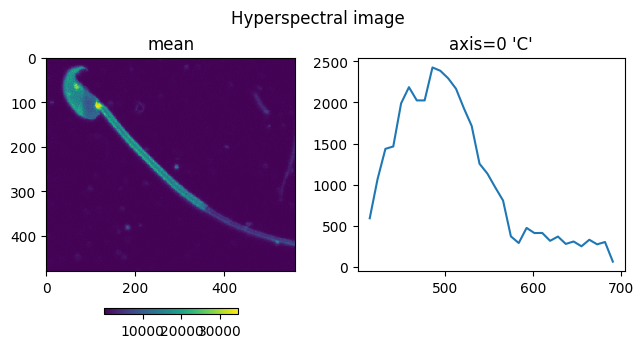

In [ ]:
plotty = True
if plotty:
  plot_signal_image(signal,  title='Hyperspectral image', axis = 0)

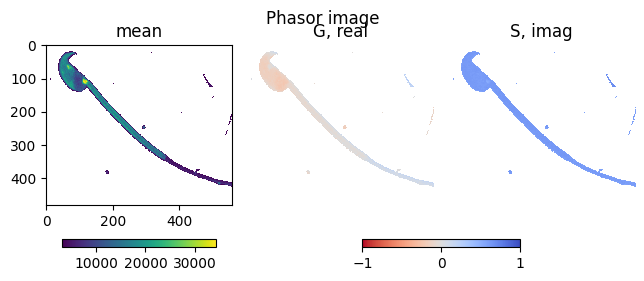

In [ ]:
mean, real, imag = phasor_from_signal(signal, axis=0)

# Median filter
mean_mf, real_mf, imag_mf = phasor_filter_median(mean, real, imag, size=3, repeat=3)
# Threshold
mean_th, real_th, imag_th = phasor_threshold(mean_mf, real_mf, imag_mf, mean_min=3000)

plot_phasor_image(mean_th, real_th, imag_th, title='Phasor image')



## Polar cursors to create pseudocolored images with user-defined color names

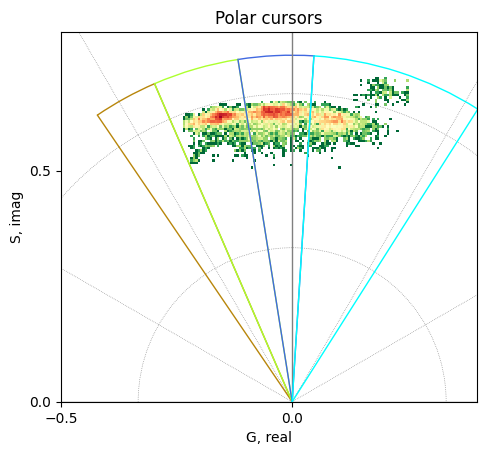

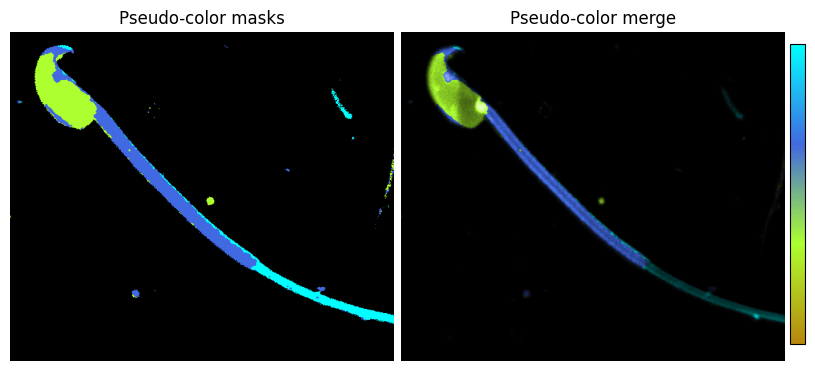

In [ ]:
from matplotlib.colors import to_rgb, LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase

# Setup
os.makedirs(save_folder, exist_ok=True)
base_filename = os.path.splitext(os.path.basename(original_filename))[0]
phasor_path = os.path.join(save_folder, f"{base_filename}_phasor_plot.tiff")
merge_path = os.path.join(save_folder, f"{base_filename}_pscolor_merge.tiff")

# User-defined color names
custom_color_names = ['darkgoldenrod', 'greenyellow', 'royalblue', 'aqua']
custom_colors = np.array([to_rgb(c) for c in custom_color_names])

# Compute mask
polar_mask = mask_from_polar_cursor(
    real_th, imag_th, phase_min, phase_max, modulation_min, modulation_max
)

# Save phasor plot
plot = PhasorPlot(allquadrants=True, title='Polar cursors')
plot.hist2d(real_th, imag_th, cmap='RdYlGn_r', bins=400)

for i in range(len(phase_min)):
    plot.polar_cursor(
        phase=phase_min[i],
        phase_limit=phase_max[i],
        modulation=modulation_min[i],
        modulation_limit=modulation_max[i],
        color=custom_colors[i],
        linestyle='-',
    )

plt.xlim(x0, x1)
plt.ylim(y0, y1)
plt.savefig(phasor_path, dpi=300, format='tiff')
plot.show()

# Generate pseudo-color images
pseudo_color_masks = pseudo_color(*polar_mask, intensity=None, colors=custom_colors)
pseudo_color_merge = pseudo_color(*polar_mask, intensity=mean, colors=custom_colors, vmin=1000, vmax=40000)

# Create side-by-side figure with reduced spacing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'wspace': 0.02})

# Pseudocolor masks
ax1.set_title('Pseudo-color masks')
ax1.imshow(pseudo_color_masks)
ax1.axis('off')

# Pseudocolor merge
ax2.set_title('Pseudo-color merge')
im = ax2.imshow(pseudo_color_merge)
ax2.axis('off')

# Colorbar
cmap = LinearSegmentedColormap.from_list("membrane_cmap", custom_color_names)
norm = plt.Normalize(vmin=0, vmax=1)
cbar_ax = fig.add_axes([0.905, 0.2, 0.015, 0.6])  # Adjust left position to move closer
cb = ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='vertical')
cb.set_ticks([])
cbar_ax.set_yticklabels([])

# Save images
fig.savefig(merge_path, dpi=300, format='tiff', bbox_inches='tight')
plt.show()

## Measure the width of the flagellum: using manual rotation

(480, 560)


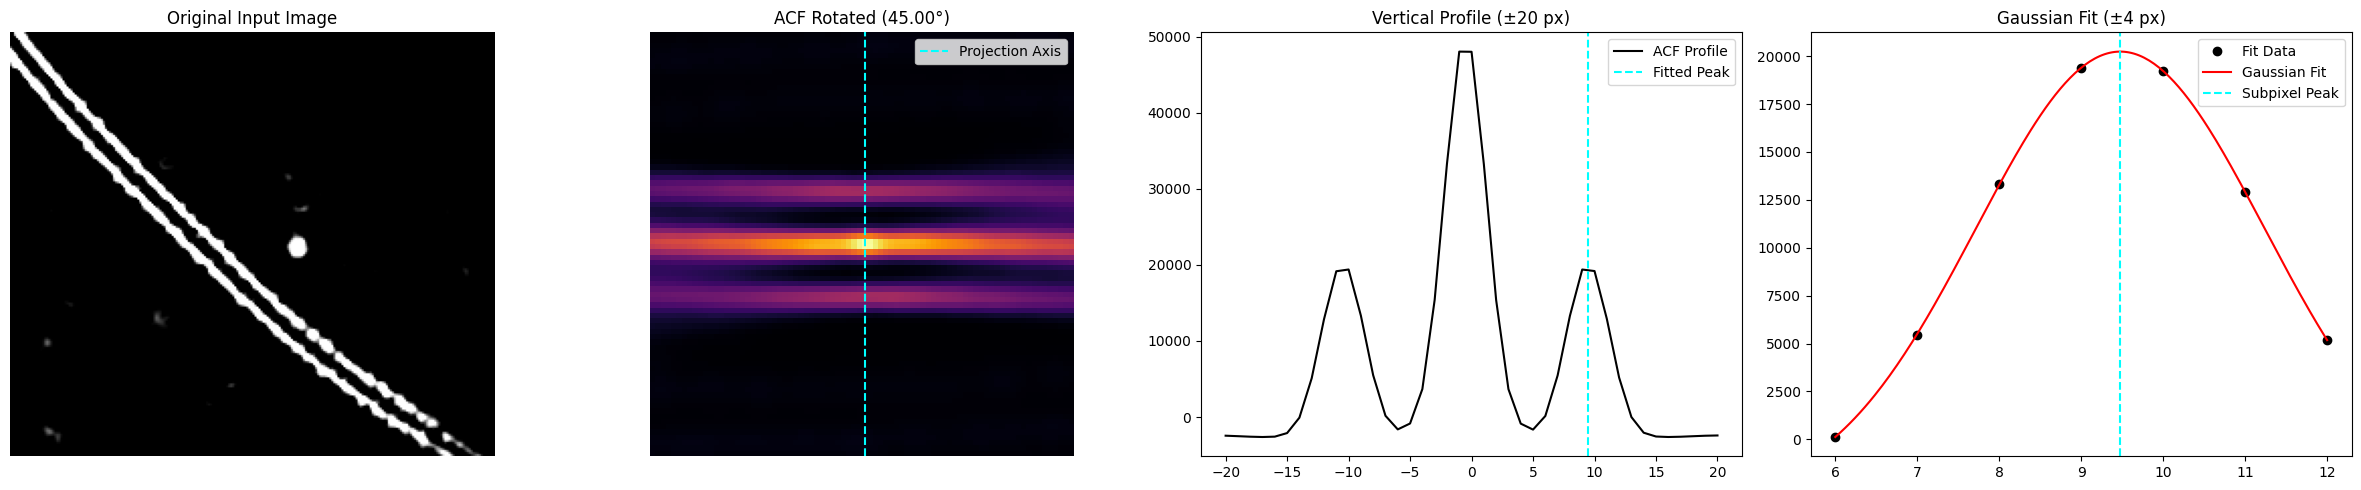

Spatial period (pixels): 9.476
Spatial period (microns): 0.624


In [ ]:
# Manual rotation control
use_manual_rotation = True  # Set to True for manual override
manual_angle = 45    # Degrees, positive = counterclockwise

# Gaussian model
def gaussian(x, a, x0, sigma, c):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + c

# Image input
image = mean_mssr1[140:350, 150:390]
print(mean_mssr1.shape)
if image.ndim == 3:
    image = rgb2gray(image)

# Normalize
image = (image - np.mean(image)) / np.std(image)

# Autocorrelation
f_image = fft2(image)
autocorr = fftshift(np.real(ifft2(np.abs(f_image)**2)))
center = np.array(autocorr.shape) // 2

# Compute rotation angle
if use_manual_rotation:
    final_angle = manual_angle
else:
    y_indices, x_indices = np.indices(autocorr.shape)
    positions = np.stack((x_indices.flatten(), y_indices.flatten()), axis=1)
    weights = autocorr.flatten()
    weights = np.clip(weights, a_min=0, a_max=None)

    valid = weights > np.percentile(weights, 80)
    positions = positions[valid]
    weights = weights[valid]
    positions_centered = positions - np.mean(positions, axis=0)

    cov = np.cov(positions_centered.T, aweights=weights)
    eigvals, eigvecs = np.linalg.eigh(cov)
    first_pc = eigvecs[:, 1]
    final_angle = -np.rad2deg(np.arctan2(first_pc[0], first_pc[1])) - 90

# Rotate ACF
rotated_acf = rotate(autocorr, angle=final_angle, reshape=False, order=3, mode='reflect')

# Vertical profile from rotated ACF
center_rot = np.array(rotated_acf.shape) // 2
line_start = center_rot[0] - search_range
line_end = center_rot[0] + search_range + 1
vertical_line = rotated_acf[line_start:line_end, center_rot[1]]
x = np.arange(-search_range, search_range + 1)

# Peak detection and Gaussian fit
positive_half = vertical_line[search_range + 1:]
peaks, _ = find_peaks(positive_half)

refined_peak = 0
x_fit, y_fit, x_fine, fit_curve = None, None, None, None

if len(peaks) > 0:
    peak_index = peaks[0] + search_range + 1
    fit_start = max(0, peak_index - fit_half_width)
    fit_end = min(len(vertical_line), peak_index + fit_half_width + 1)

    x_fit = x[fit_start:fit_end]
    y_fit = vertical_line[fit_start:fit_end]
    initial_guess = [y_fit.max() - y_fit.min(), x[peak_index], 1.0, y_fit.min()]
    try:
        popt, _ = curve_fit(gaussian, x_fit, y_fit, p0=initial_guess)
        refined_peak = popt[1]
        x_fine = np.linspace(x_fit[0], x_fit[-1], 200)
        fit_curve = gaussian(x_fine, *popt)
    except RuntimeError:
        refined_peak = x[peak_index]

# Convert to microns
spatial_period_pixels = refined_peak
spatial_period_um = spatial_period_pixels * pixel_size

# Zoom limits
y1 = max(0, center[0] - zoom_radius)
y2 = min(autocorr.shape[0], center[0] + zoom_radius)
x1 = max(0, center[1] - zoom_radius)
x2 = min(autocorr.shape[1], center[1] + zoom_radius)

# Plotting
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

# Original image
axs[0].imshow(image, cmap='gray', vmin=0, vmax=2)
axs[0].set_title('Original Input Image')
axs[0].axis('off')

# Rotated ACF
axs[1].imshow(rotated_acf[y1:y2, x1:x2], cmap='inferno', origin='upper')
axs[1].axvline(x=center[1] - x1, color='cyan', linestyle='--', label='Projection Axis')
axs[1].set_title(f'ACF Rotated ({final_angle:.2f}°)')
axs[1].legend()
axs[1].axis('off')

# Projection profile
axs[2].plot(x, vertical_line, color='black', label='ACF Profile')
if refined_peak != 0:
    axs[2].axvline(x=refined_peak, color='cyan', linestyle='--', label='Fitted Peak')
axs[2].set_title('Vertical Profile (±20 px)')
axs[2].legend()

# Gaussian fit
if x_fit is not None and y_fit is not None and fit_curve is not None:
    axs[3].plot(x_fit, y_fit, 'ko', label='Fit Data')
    axs[3].plot(x_fine, fit_curve, 'r-', label='Gaussian Fit')
    axs[3].axvline(x=refined_peak, color='cyan', linestyle='--', label='Subpixel Peak')
    axs[3].set_title('Gaussian Fit (±4 px)')
    axs[3].legend()
else:
    axs[3].text(0.5, 0.5, 'Fit Failed or No Peak Detected', ha='center', va='center')
    axs[3].axis('off')

plt.tight_layout()
plt.show()

# Output
print(f'Spatial period (pixels): {spatial_period_pixels:.3f}')
print(f'Spatial period (microns): {spatial_period_um:.3f}')

import csv  # Add at the top if not already imported

# Save spatial period to CSV file

base_filename = os.path.splitext(os.path.basename(original_filename))[0]
csv_path = os.path.join(save_folder, f"{base_filename}_flagellum_widht.csv")

# Write CSV with headers and values
with open(csv_path, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Metric", "Value"])
    writer.writerow(["Spatial period (pixels)", f"{spatial_period_pixels:.3f}"])
    writer.writerow(["Spatial period (microns)", f"{spatial_period_um:.3f}"])

## Measure the width of the flagellum: automatically

(480, 560)


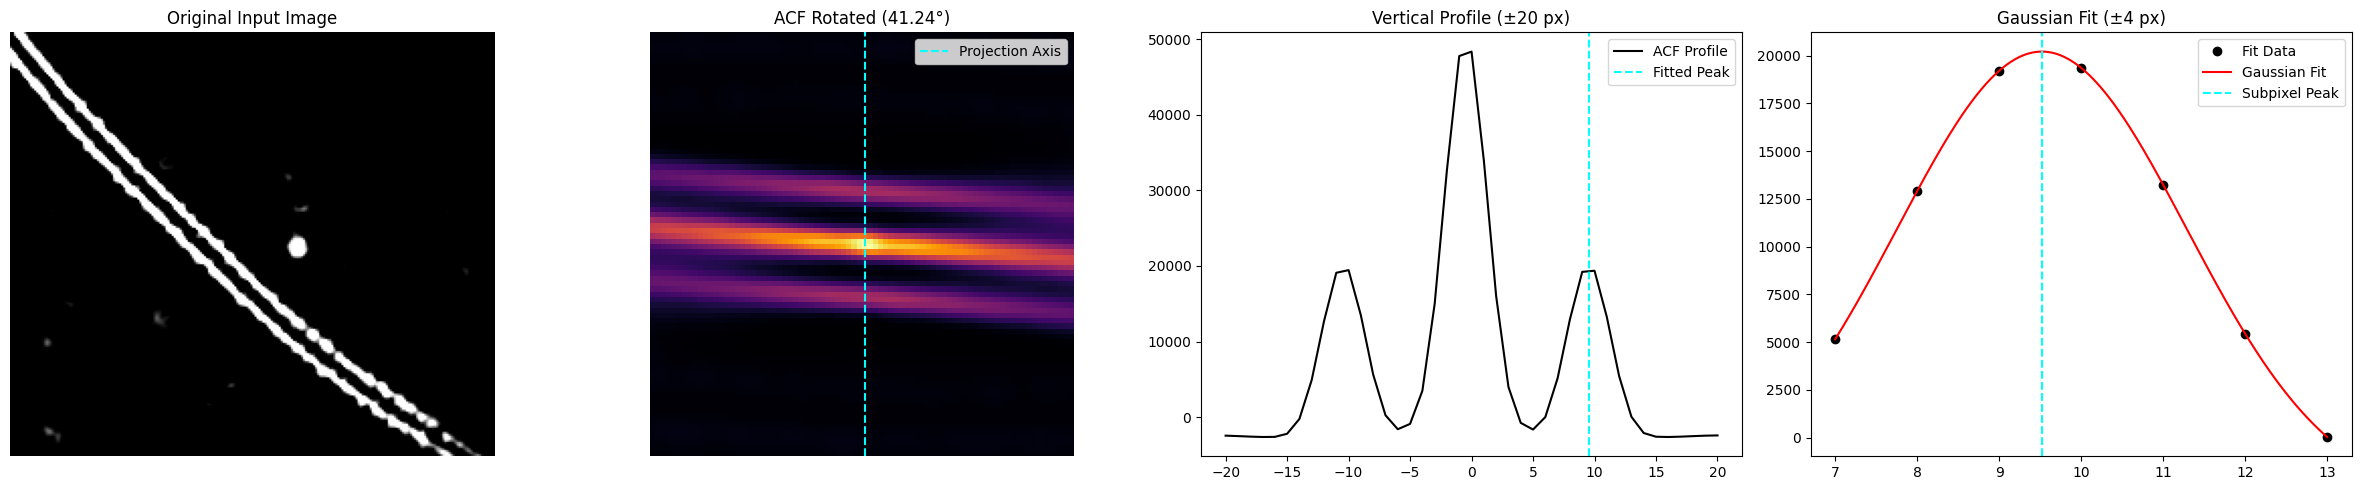

Spatial period (pixels): 9.520
Spatial period (microns): 0.627


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift
from scipy.ndimage import rotate
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

# Gaussian model
def gaussian(x, a, x0, sigma, c):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + c


# Image input
image = mean_mssr1[140:350, 150:390]
print(mean_mssr1.shape)
if image.ndim == 3:
    image = rgb2gray(image)

# Normalize
image = (image - np.mean(image)) / np.std(image)

# Autocorrelation
f_image = fft2(image)
autocorr = fftshift(np.real(ifft2(np.abs(f_image)**2)))
center = np.array(autocorr.shape) // 2

# PCA on autocorrelation
y_indices, x_indices = np.indices(autocorr.shape)
positions = np.stack((x_indices.flatten(), y_indices.flatten()), axis=1)
weights = autocorr.flatten()
weights = np.clip(weights, a_min=0, a_max=None)  # ensure non-negative weights

# Use only high-intensity pixels for PCA
valid = weights > np.percentile(weights, 80)
positions = positions[valid]
weights = weights[valid]

# Center positions
positions_centered = positions - np.mean(positions, axis=0)

# Weighted covariance matrix
cov = np.cov(positions_centered.T, aweights=weights)
eigvals, eigvecs = np.linalg.eigh(cov)

# First principal component (maximum variance direction)
first_pc = eigvecs[:, 1]

# Compute angle to align 1st PC with x-axis
rotation_angle = -np.rad2deg(np.arctan2(first_pc[0], first_pc[1]))
rotated_acf = rotate(autocorr, angle=rotation_angle - 90, reshape=False, order=3, mode='reflect')

# Vertical profile from rotated ACF (projection direction)
center_rot = np.array(rotated_acf.shape) // 2
line_start = center_rot[0] - search_range
line_end = center_rot[0] + search_range + 1
vertical_line = rotated_acf[line_start:line_end, center_rot[1]]
x = np.arange(-search_range, search_range + 1)

# Peak detection and fit
positive_half = vertical_line[search_range + 1:]
peaks, _ = find_peaks(positive_half)

refined_peak = 0
x_fit, y_fit, x_fine, fit_curve = None, None, None, None

if len(peaks) > 0:
    peak_index = peaks[0] + search_range + 1
    fit_start = max(0, peak_index - fit_half_width)
    fit_end = min(len(vertical_line), peak_index + fit_half_width + 1)

    x_fit = x[fit_start:fit_end]
    y_fit = vertical_line[fit_start:fit_end]

    initial_guess = [y_fit.max() - y_fit.min(), x[peak_index], 1.0, y_fit.min()]
    try:
        popt, _ = curve_fit(gaussian, x_fit, y_fit, p0=initial_guess)
        refined_peak = popt[1]
        x_fine = np.linspace(x_fit[0], x_fit[-1], 200)
        fit_curve = gaussian(x_fine, *popt)
    except RuntimeError:
        refined_peak = x[peak_index]

# Convert to microns
spatial_period_pixels = refined_peak
spatial_period_um = spatial_period_pixels * pixel_size

# Zoom limits
y1 = max(0, center[0] - zoom_radius)
y2 = min(autocorr.shape[0], center[0] + zoom_radius)
x1 = max(0, center[1] - zoom_radius)
x2 = min(autocorr.shape[1], center[1] + zoom_radius)

# Plotting
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

# Original input image
axs[0].imshow(image, cmap='gray', vmin=0, vmax=2)
axs[0].set_title('Original Input Image')
axs[0].axis('off')

# Rotated ACF
axs[1].imshow(rotated_acf[y1:y2, x1:x2], cmap='inferno', origin='upper')
axs[1].axvline(x=center[1] - x1, color='cyan', linestyle='--', label='Projection Axis')
axs[1].set_title(f'ACF Rotated ({rotation_angle - 90:.2f}°)')
axs[1].legend()
axs[1].axis('off')

# Vertical profile
axs[2].plot(x, vertical_line, color='black', label='ACF Profile')
if refined_peak != 0:
    axs[2].axvline(x=refined_peak, color='cyan', linestyle='--', label='Fitted Peak')
axs[2].set_title('Vertical Profile (±20 px)')
axs[2].legend()

# Fit detail
if x_fit is not None and y_fit is not None and fit_curve is not None:
    axs[3].plot(x_fit, y_fit, 'ko', label='Fit Data')
    axs[3].plot(x_fine, fit_curve, 'r-', label='Gaussian Fit')
    axs[3].axvline(x=refined_peak, color='cyan', linestyle='--', label='Subpixel Peak')
    axs[3].set_title('Gaussian Fit (±4 px)')
    axs[3].legend()
else:
    axs[3].text(0.5, 0.5, 'Fit Failed or No Peak Detected', ha='center', va='center')
    axs[3].axis('off')

plt.tight_layout()
plt.show()

# Output
print(f'Spatial period (pixels): {spatial_period_pixels:.3f}')
print(f'Spatial period (microns): {spatial_period_um:.3f}')
